<a href="https://colab.research.google.com/github/saloniwalimbe/Mutual-Fund-Schemes/blob/main/Neutral_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import math
import random
import datetime
from urllib.request import urlopen
import csv
import warnings
warnings.filterwarnings('ignore')     #suppress unwanted warnings
import numpy as np
import pandas as pd
from scipy.optimize import minimize, Bounds
import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('seaborn-whitegrid')

from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from keras.optimizers import SGD
from sklearn.metrics import mean_squared_error

In [ ]:
dailynav = 'https://raw.githubusercontent.com/saloniwalimbe/Mutual-Fund-Schemes/main/DailyNAV.csv'

In [ ]:
f = urlopen(dailynav)
data = f.read()
data = data.decode('utf-8')
data = data.split('\n')

list_for_df = []
for line in data[1:]:
  row = line.split(',')
  if row != '':
    list_for_df.append(row)

df = pd.DataFrame(list_for_df, columns= ['NAV_Date',
                                         'Axis_Equity','CanaraRobeco_Bluechip','Franklin_Bluechip','ICICI_FocusedEq','Kotak_Bluechip','Kotak_Flexicap','SBI_Bluechip','SBI_FocusedEq',
                                         'AdityaBirla_EqHybrid','Franklin_EqHybrid','HDFC_EqHybrid','SBI_EqHybrid',
                                         'Kotak_EqArbitrage','SBI_Arbitrage','LIC_Bond','LIC_DebtHybrid'
                                        ]
                 )


df['NAV_Date'] = pd.to_datetime(df['NAV_Date'], infer_datetime_format=True)
df['Axis_Equity'] = pd.to_numeric(df['Axis_Equity'])
df['CanaraRobeco_Bluechip'] = pd.to_numeric(df['CanaraRobeco_Bluechip'])
df['Franklin_Bluechip'] = pd.to_numeric(df['Franklin_Bluechip'])
df['ICICI_FocusedEq'] = pd.to_numeric(df['ICICI_FocusedEq'])
df['Kotak_Bluechip'] = pd.to_numeric(df['Kotak_Bluechip'])
df['Kotak_Flexicap'] = pd.to_numeric(df['Kotak_Flexicap'])
df['SBI_Bluechip'] = pd.to_numeric(df['SBI_Bluechip'], errors = "ignore")
df['SBI_FocusedEq'] = pd.to_numeric(df['SBI_FocusedEq'], errors = "ignore")
df['AdityaBirla_EqHybrid'] = pd.to_numeric(df['AdityaBirla_EqHybrid'], errors = "ignore")
df['Franklin_EqHybrid'] = pd.to_numeric(df['Franklin_EqHybrid'], errors = "ignore")
df['HDFC_EqHybrid'] = pd.to_numeric(df['HDFC_EqHybrid'], errors = "ignore")
df['SBI_EqHybrid'] = pd.to_numeric(df['SBI_EqHybrid'], errors = "ignore")
df['Kotak_EqArbitrage'] = pd.to_numeric(df['Kotak_EqArbitrage'], errors = "ignore")
df['SBI_Arbitrage'] = pd.to_numeric(df['SBI_Arbitrage'], errors = "ignore")
df['LIC_Bond'] = pd.to_numeric(df['LIC_Bond'], errors = "ignore")
df['LIC_DebtHybrid'] = pd.to_numeric(df['LIC_DebtHybrid'], errors = "ignore")


df = df.set_index('NAV_Date')

df = df.dropna()



In [ ]:
def return_rmse(test,predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {}.".format(rmse))

In [ ]:
df1 = pd.DataFrame(df.T.iloc[[0,7,8,9,10,11,12,15]])
df1 = df1.T
df1

,Axis_Equity,SBI_FocusedEq,AdityaBirla_EqHybrid,Franklin_EqHybrid,HDFC_EqHybrid,SBI_EqHybrid,Kotak_EqArbitrage,LIC_DebtHybrid
NAV_Date,,,,,,,,
2013-01-01,14.9149,61.4600,348.92,55.1533,28.957,56.7200,16.9361,35.2934
2013-01-02,15.0251,61.9100,350.97,55.2697,29.227,56.9600,16.9652,35.3290
2013-01-03,15.0732,62.4900,352.69,55.5012,29.316,57.5800,16.9610,35.3497
2013-01-04,15.0695,62.5000,353.10,55.5513,29.381,57.6600,16.9658,35.3660
2013-01-07,15.0370,62.3600,352.50,55.6576,29.348,57.7100,16.9742,35.3826
...,...,...,...,...,...,...,...,...
2022-12-22,65.3769,229.2696,1030.20,180.8508,84.005,207.4258,31.2420,68.6033
2022-12-23,64.0594,225.9170,1042.56,182.9713,85.226,204.5794,31.2474,68.3683
2022-12-26,64.8110,228.4033,1048.33,183.7410,85.640,206.7416,31.2668,68.5005


In [ ]:
list_of_mf = ['Axis_Equity', 'SBI_FocusedEq', 'AdityaBirla_EqHybrid','Franklin_EqHybrid', 'HDFC_EqHybrid', 'SBI_EqHybrid','Kotak_EqArbitrage', 'LIC_DebtHybrid']

In [ ]:
df_ = {}
for i in list_of_mf:
  df_[i] = df1[i]

In [ ]:
def split(dataframe, border):
    return dataframe.loc[:border,], dataframe.loc[border:,]

In [ ]:
df_new = {}
for i in list_of_mf:
    df_new[i] = {}
    #df_new[i]['Train'], df_new[i]["Test"] = int(len(df_)*0.75), (int(len(df_)*0.25))
    df_new[i]['Train'], df_new[i]["Test"] = split(df_[i], pd.to_datetime('2021-01-01'))

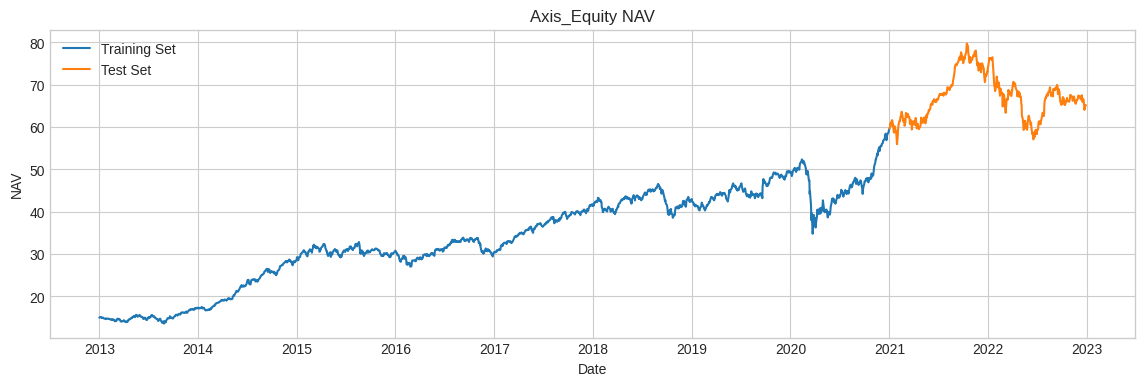

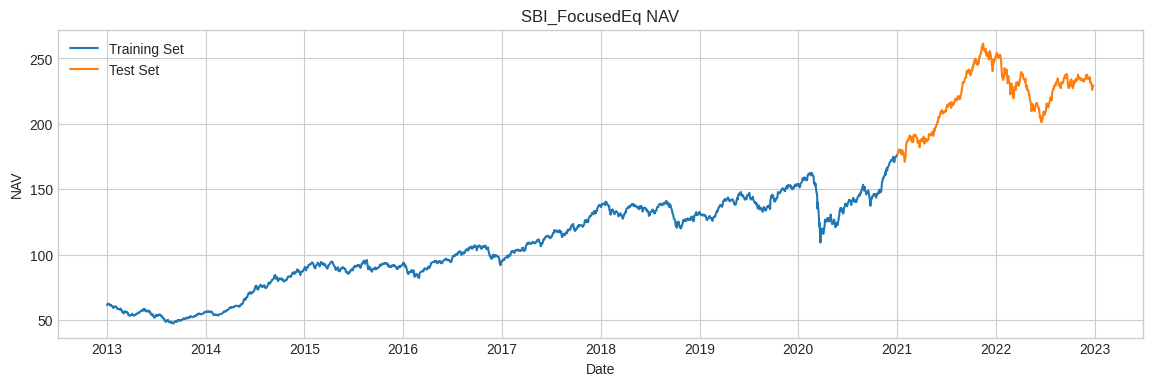

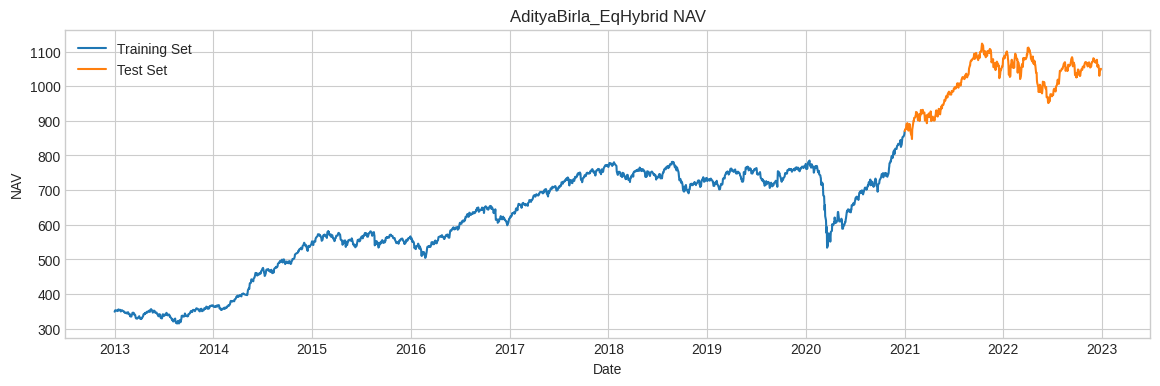

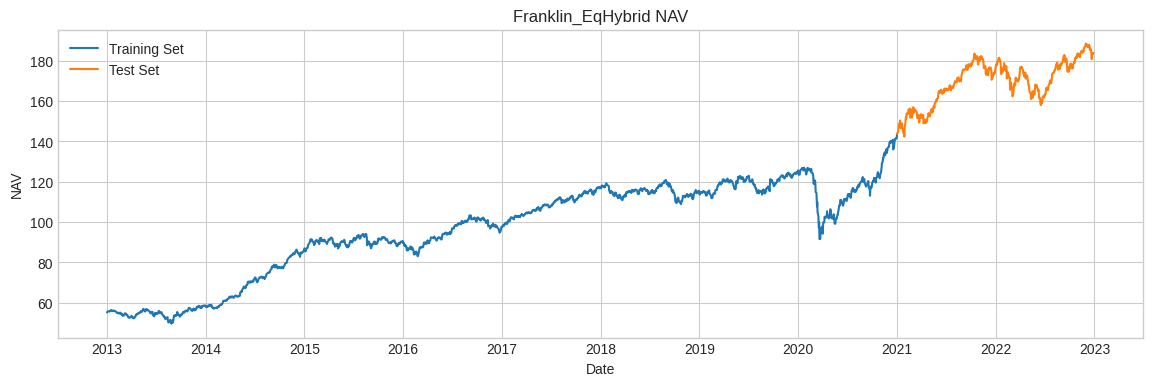

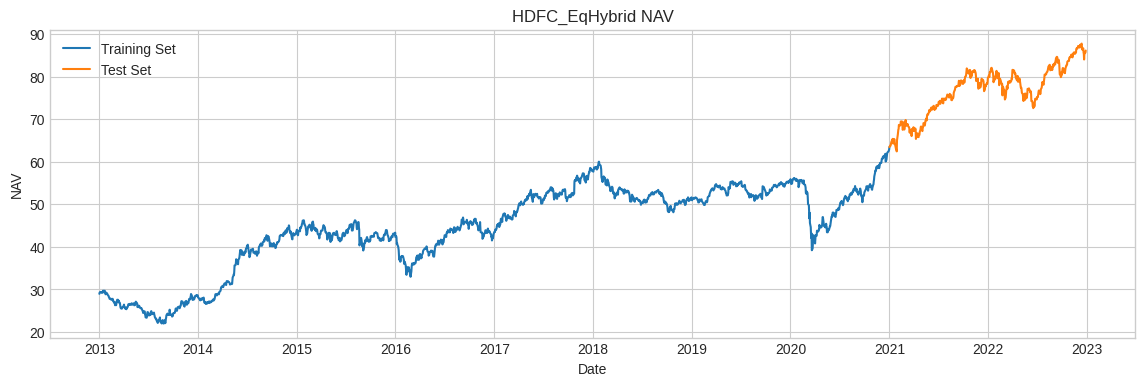

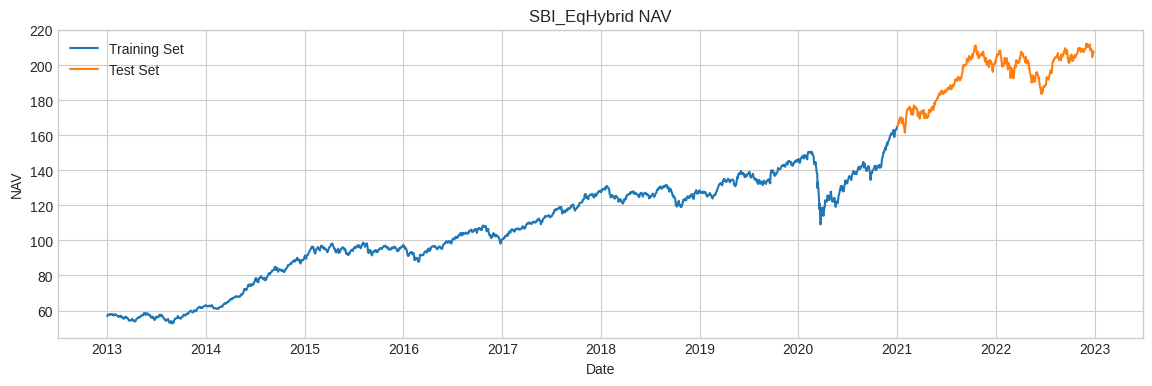

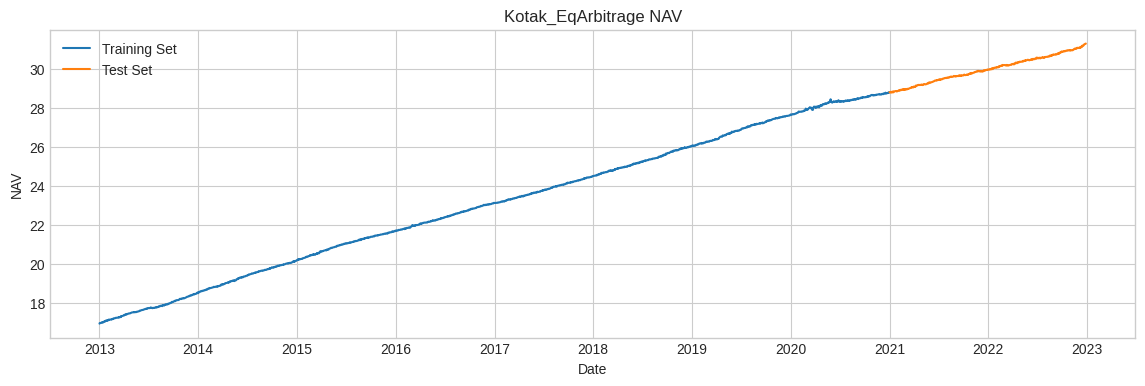

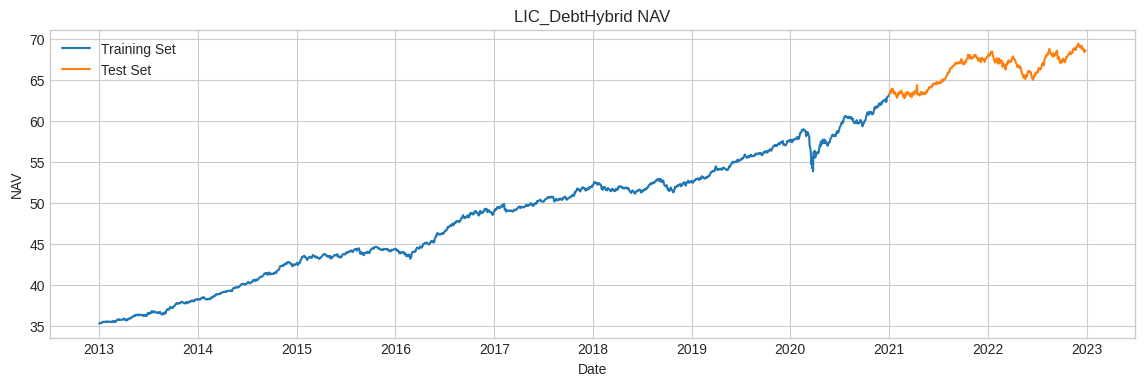

In [ ]:
for i in list_of_mf:
    plt.figure(figsize=(14,4))
    plt.plot(df_new[i]["Train"])
    plt.plot(df_new[i]["Test"])
    plt.ylabel("NAV")
    plt.xlabel("Date")
    plt.legend(["Training Set", "Test Set"])
    plt.title(i + " NAV")

In [ ]:
# Scaling the training set
transform_train = {}
transform_test = {}
scaler = {}

for num, i in enumerate(list_of_mf):
    sc = MinMaxScaler(feature_range=(0,1))
    a0 = np.array(df_new[i]["Train"])
    a1 = np.array(df_new[i]["Test"])
    a0 = a0.reshape(a0.shape[0],1)
    a1 = a1.reshape(a1.shape[0],1)
    transform_train[i] = sc.fit_transform(a0)
    transform_test[i] = sc.fit_transform(a1)
    scaler[i] = sc

del a0
del a1

In [ ]:
for i in transform_train.keys():
    print(i, transform_train[i].shape)
print("\n")    
for i in transform_test.keys():
    print(i, transform_test[i].shape)

Axis_Equity (1969, 1)
SBI_FocusedEq (1969, 1)
AdityaBirla_EqHybrid (1969, 1)
Franklin_EqHybrid (1969, 1)
HDFC_EqHybrid (1969, 1)
SBI_EqHybrid (1969, 1)
Kotak_EqArbitrage (1969, 1)
LIC_DebtHybrid (1969, 1)


Axis_Equity (492, 1)
SBI_FocusedEq (492, 1)
AdityaBirla_EqHybrid (492, 1)
Franklin_EqHybrid (492, 1)
HDFC_EqHybrid (492, 1)
SBI_EqHybrid (492, 1)
Kotak_EqArbitrage (492, 1)
LIC_DebtHybrid (492, 1)


In [ ]:
trainset = {}
testset = {}
for j in list_of_mf:
    trainset[j] = {}
    X_train = []
    y_train = []
    for i in range(120,1969):
        X_train.append(transform_train[j][i-120:i,0])
        y_train.append(transform_train[j][i,0])
    X_train, y_train = np.array(X_train), np.array(y_train)
    trainset[j]["X"] = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))
    trainset[j]["y"] = y_train
    
    testset[j] = {}
    X_test = []
    y_test = []    
    for i in range(120, 492):
        X_test.append(transform_test[j][i-120:i,0])
        y_test.append(transform_test[j][i,0])
    X_test, y_test = np.array(X_test), np.array(y_test)
    testset[j]["X"] = np.reshape(X_test, (X_test.shape[0], X_train.shape[1], 1))
    testset[j]["y"] = y_test

In [ ]:
arr_buff = []
for i in list_of_mf:
    buff = {}
    buff["X_train"] = trainset[i]["X"].shape
    buff["y_train"] = trainset[i]["y"].shape
    buff["X_test"] = testset[i]["X"].shape
    buff["y_test"] = testset[i]["y"].shape
    arr_buff.append(buff)

pd.DataFrame(arr_buff, index=list_of_mf)

,X_train,y_train,X_test,y_test
Axis_Equity,"(1849, 120, 1)","(1849,)","(372, 120, 1)","(372,)"
SBI_FocusedEq,"(1849, 120, 1)","(1849,)","(372, 120, 1)","(372,)"
AdityaBirla_EqHybrid,"(1849, 120, 1)","(1849,)","(372, 120, 1)","(372,)"
Franklin_EqHybrid,"(1849, 120, 1)","(1849,)","(372, 120, 1)","(372,)"
HDFC_EqHybrid,"(1849, 120, 1)","(1849,)","(372, 120, 1)","(372,)"
SBI_EqHybrid,"(1849, 120, 1)","(1849,)","(372, 120, 1)","(372,)"
Kotak_EqArbitrage,"(1849, 120, 1)","(1849,)","(372, 120, 1)","(372,)"
LIC_DebtHybrid,"(1849, 120, 1)","(1849,)","(372, 120, 1)","(372,)"


In [ ]:
%%time
# The LSTM architecture
regressor = Sequential()
# First LSTM layer with Dropout regularisation
regressor.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)))
regressor.add(Dropout(0.2))
# Second LSTM layer
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))
# Third LSTM layer
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.5))
# Fourth LSTM layer
regressor.add(LSTM(units=50))
regressor.add(Dropout(0.5))
# The output layer
regressor.add(Dense(units=1))

# Compiling the RNN
regressor.compile(optimizer='rmsprop', loss='mean_squared_error')
# Fitting to the training set
for i in list_of_mf:
    print("Fitting to", i)
    regressor.fit(trainset[i]["X"], trainset[i]["y"], epochs=10, batch_size=200)

Fitting to Axis_Equity
Epoch 1/10
10/10 [==============================] - 19s 948ms/step - loss: 0.0666
Epoch 2/10
10/10 [==============================] - 9s 948ms/step - loss: 0.0173
Epoch 3/10
10/10 [==============================] - 8s 780ms/step - loss: 0.0190
Epoch 4/10
10/10 [==============================] - 9s 956ms/step - loss: 0.0174
Epoch 5/10
10/10 [==============================] - 9s 952ms/step - loss: 0.0160
Epoch 6/10
10/10 [==============================] - 8s 776ms/step - loss: 0.0170
Epoch 7/10
10/10 [==============================] - 9s 881ms/step - loss: 0.0148
Epoch 8/10
10/10 [==============================] - 9s 957ms/step - loss: 0.0132
Epoch 9/10
10/10 [==============================] - 9s 857ms/step - loss: 0.0141
Epoch 10/10
10/10 [==============================] - 9s 783ms/step - loss: 0.0131
Fitting to SBI_FocusedEq
Epoch 1/10
10/10 [==============================] - 11s 1s/step - loss: 0.0126
Epoch 2/10
10/10 [==============================] - 9s 948ms/

12/12 [==============================] - 1s 68ms/step


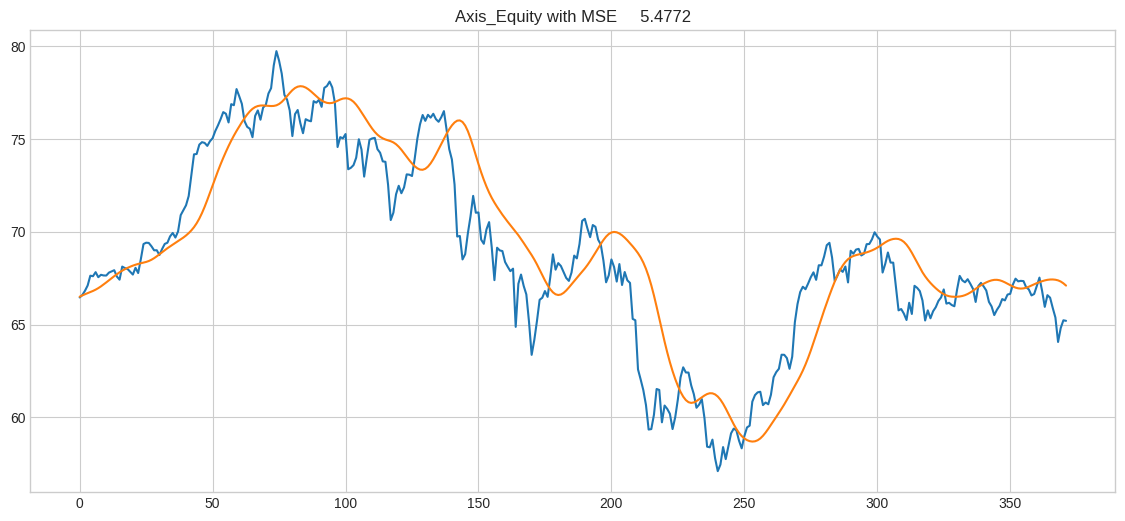

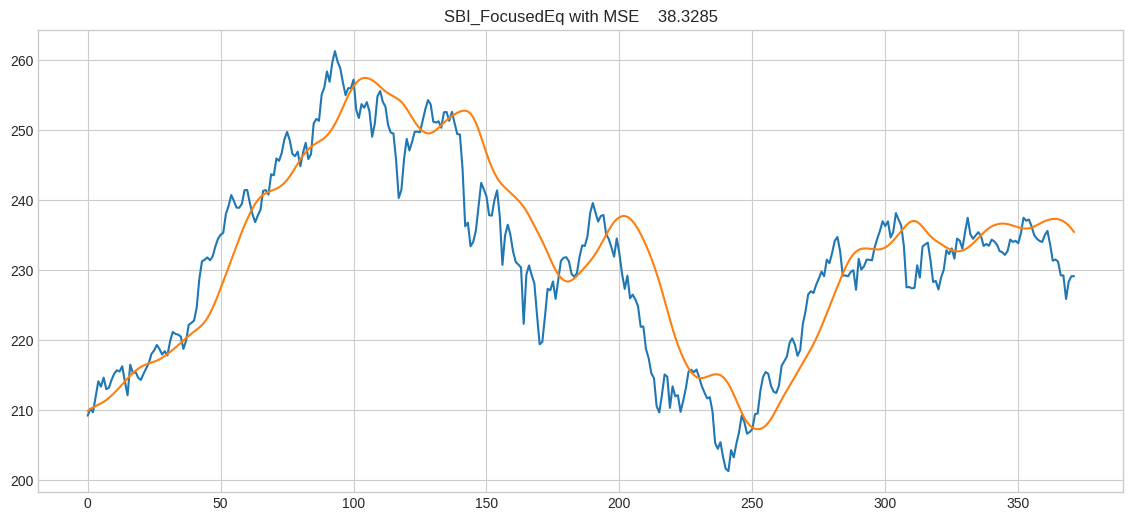

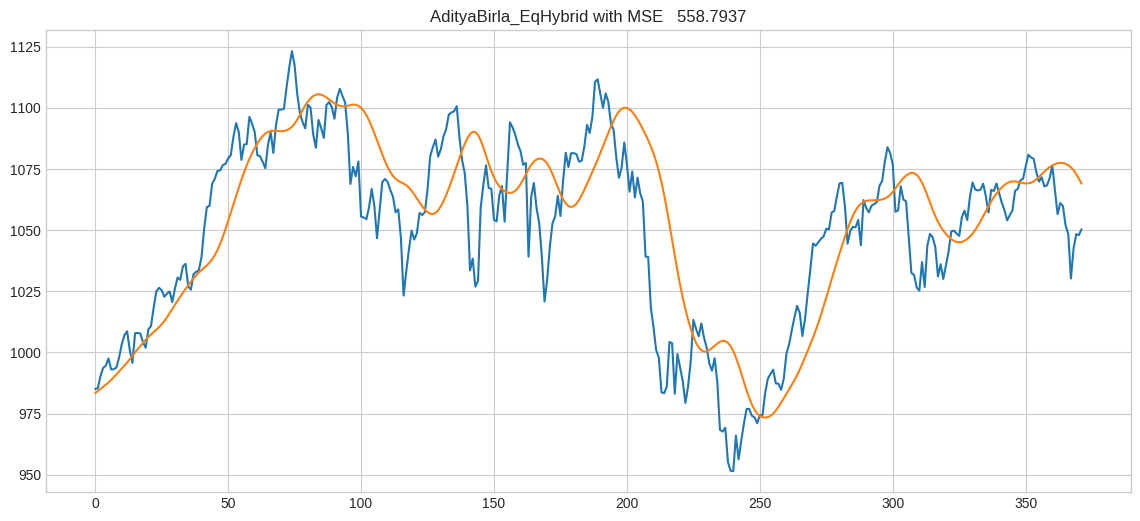

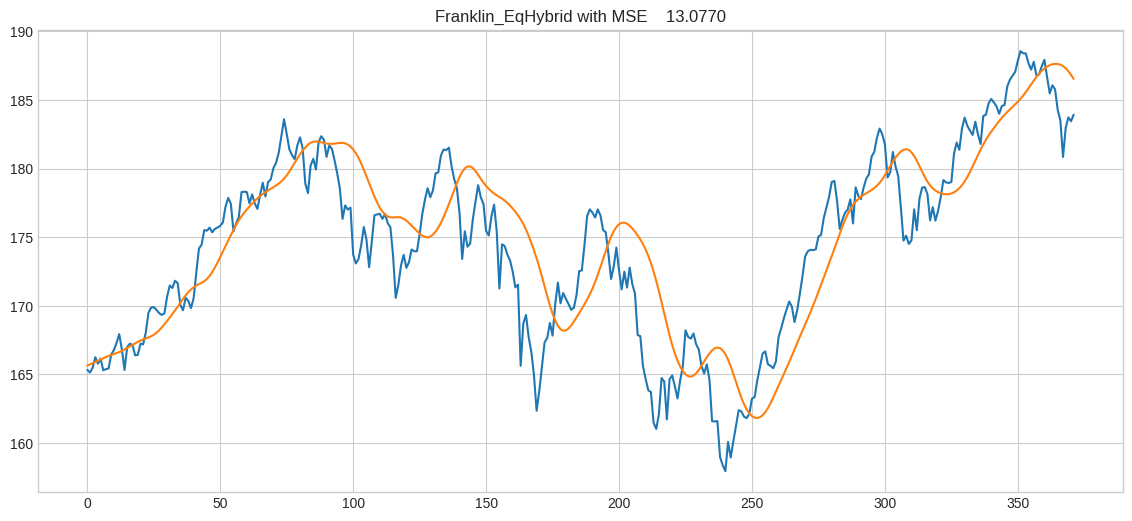

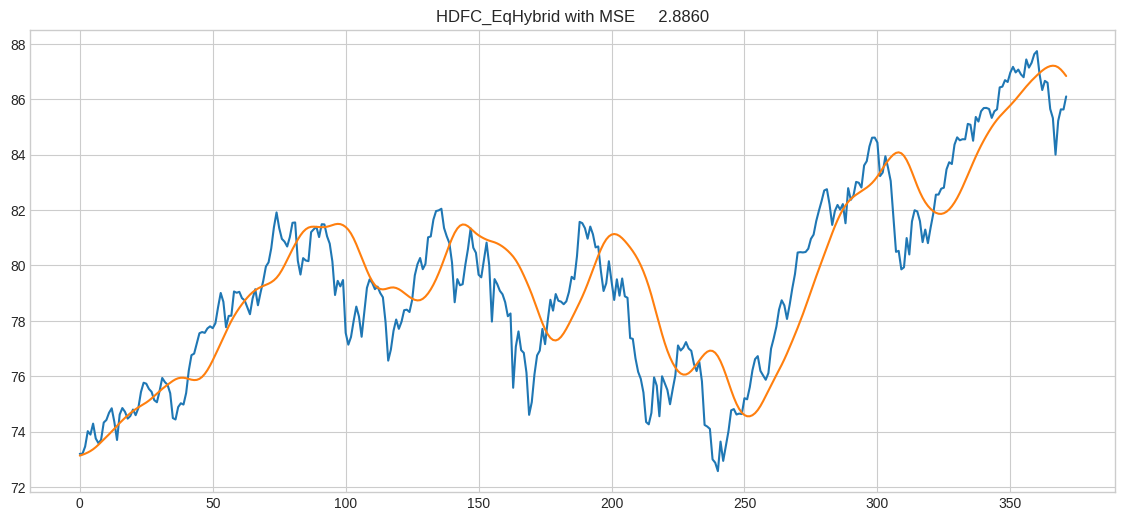

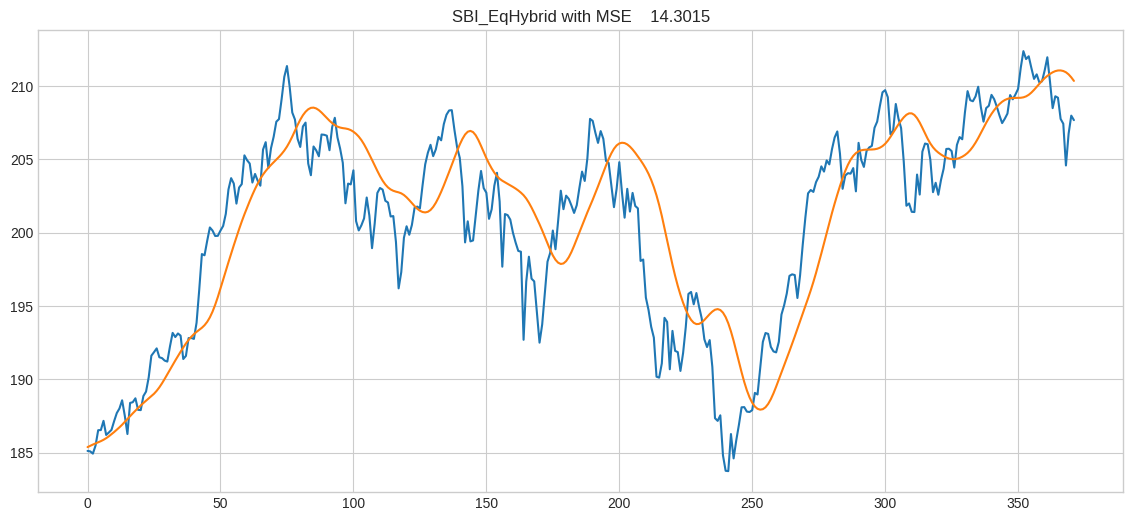

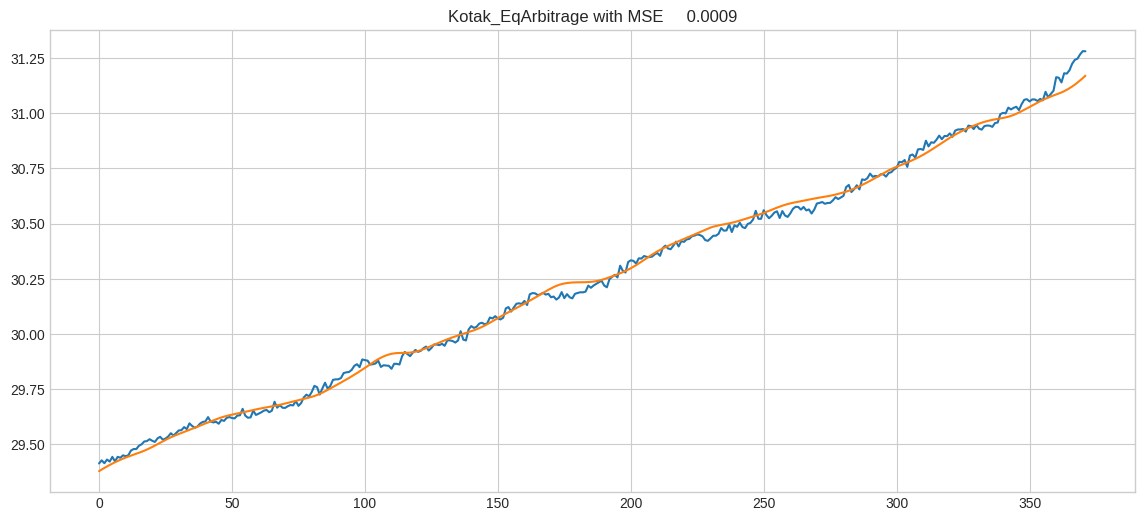

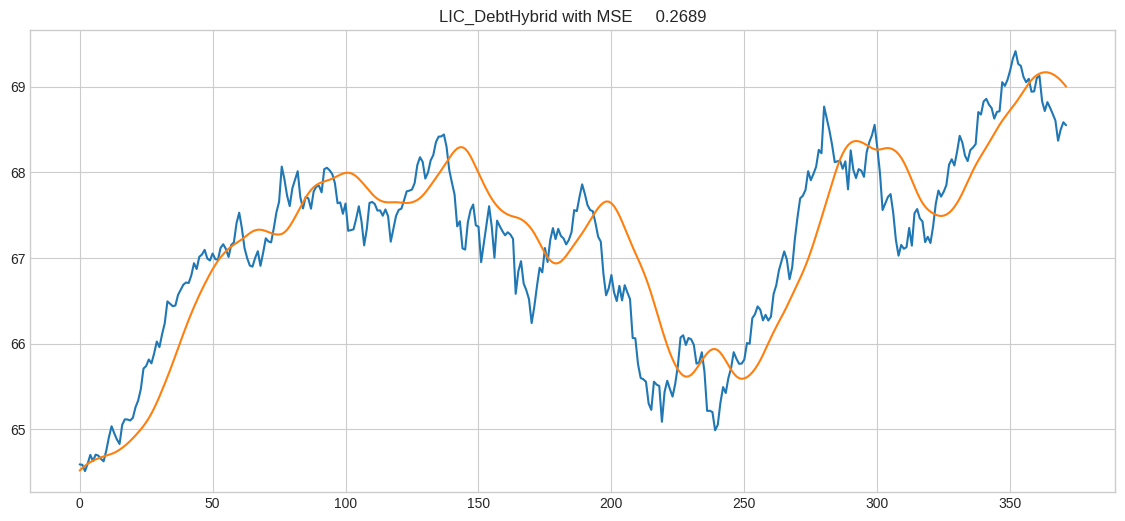

In [ ]:
pred_result = {}
for i in list_of_mf:
    y_true = scaler[i].inverse_transform(testset[i]["y"].reshape(-1,1))
    y_pred = scaler[i].inverse_transform(regressor.predict(testset[i]["X"]))
    MSE = mean_squared_error(y_true, y_pred)
    pred_result[i] = {}
    pred_result[i]["True"] = y_true
    pred_result[i]["Pred"] = y_pred
    
    plt.figure(figsize=(14,6))
    plt.title("{} with MSE {:10.4f}".format(i,MSE))
    plt.plot(y_true)
    plt.plot(y_pred)